## Imports

In [170]:
import numpy as np
from fastdtw import fastdtw
from scipy.spatial.distance import cdist, squareform, pdist
from scipy.stats import pearsonr, ttest_1samp, ttest_ind, zscore
from tqdm.notebook import tqdm

from khan_helpers import Experiment
from khan_helpers.constants import N_PARTICIPANTS
from khan_helpers.functions import r2z, z2r

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [2]:
exp = Experiment()

## set plotting params

In [3]:
plt.rcParams['pdf.fonttype'] = 42
sns.set_context('paper')
cmap = 'bone'

In [4]:
def permute_prop_correct(heldout_corrs, acc_labels, n_perms=1000, random_seed=None):
    assert heldout_corrs.shape == acc_labels.shape
    
    if random_seed is not None:
        old_state = np.random.get_state()
        np.random.seed(random_seed)
    
    perm_array = np.repeat(acc_labels[np.newaxis], n_perms, axis=0)
    perm_array = np.apply_along_axis(np.random.permutation, 1, perm_array)
    
    heldout_corrs = r2z(heldout_corrs)
    obs_prop_correct = (heldout_corrs * acc_labels).sum() / heldout_corrs.sum()
    perm_prop_correct = (heldout_corrs * perm_array).sum(axis=1) / heldout_corrs.sum()

    n_lt = (perm_prop_correct < obs_prop_correct).sum()
    n_le = (perm_prop_correct <= obs_prop_correct).sum()
    
    if random_seed is not None:
        np.random.set_state(old_state)
    
    return (n_lt + n_le) / (2 * n_perms)

# Does accounting for topic vector similarity enhance predictive ability?

# sanity check plots / extra ideas

In [86]:
# performances = []
# for p in exp.participants:
#     p_data = p.get_data(lecture='forces', qset=(1, 2))
# #     if p_data['accuracy'].sum() < 2 or p_data['accuracy'].sum() > 8:
# #         continue
#     performances.append(p_data['accuracy'].sum() / len(p_data))

# np.percentile(performances, 25)

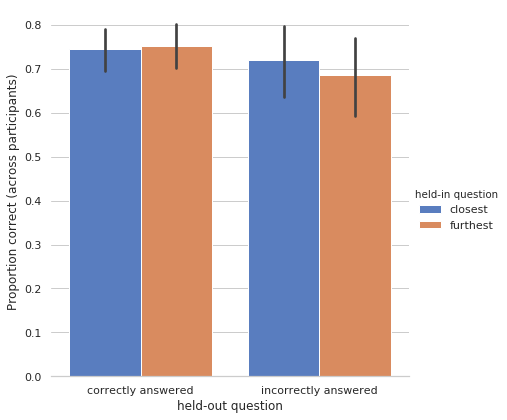

In [156]:
question_corrs = np.corrcoef(exp.question_vectors)
# question_corrs = (question_corrs + 1) / 2

closest_accs_c = []
furthest_accs_c = []
closest_accs_i = []
furthest_accs_i = []
for p in exp.participants:
    correct_corrs = []
    incorrect_corrs = []
    p_data = p.get_data(lecture='forces', qset=(1, 2))
    if p_data['accuracy'].sum() < 2 or p_data['accuracy'].sum() > 9:
        continue
#     if p_data['accuracy'].sum() / len(p_data) > 0.6:
#         continue
    
    for ix, row in p_data.iterrows():
        withheld_qid = row['qID']
        other_qdata = p_data.drop(ix)
        other_qids = other_qdata['qID']
        
        corrs = question_corrs[withheld_qid - 1, other_qids - 1]
        closest_qdata = other_qdata.iloc[corrs.argmax()]
        furthest_qdata = other_qdata.iloc[corrs.argmin()]
        
        if row['accuracy']:
            closest_accs_c.append(closest_qdata['accuracy'])
            furthest_accs_c.append(furthest_qdata['accuracy'])
        else:
            closest_accs_i.append(closest_qdata['accuracy'])
            furthest_accs_i.append(furthest_qdata['accuracy'])
            
sns.set(style="whitegrid")
df = pd.DataFrame(columns=['acc', 'held-out question', 'held-in question'])
df['acc'] = closest_accs_c + furthest_accs_c + closest_accs_i + furthest_accs_i
df['held-out question'] = (['correctly answered'] * len(closest_accs_c + furthest_accs_c) + 
                           ['incorrectly answered'] * len(closest_accs_i + furthest_accs_i))
df['held-in question'] = (['closest'] * len(closest_accs_c) + 
                   ['furthest'] * len(furthest_accs_c) + 
                   ['closest'] * len(closest_accs_i) + 
                   ['furthest'] * len(furthest_accs_i))

g = sns.catplot(x='held-out question', y='acc', hue='held-in question', data=df, 
                height=6, kind='bar', palette='muted')
g.despine(left=True)
g.set_ylabels("Proportion correct (across participants)")
plt.show()

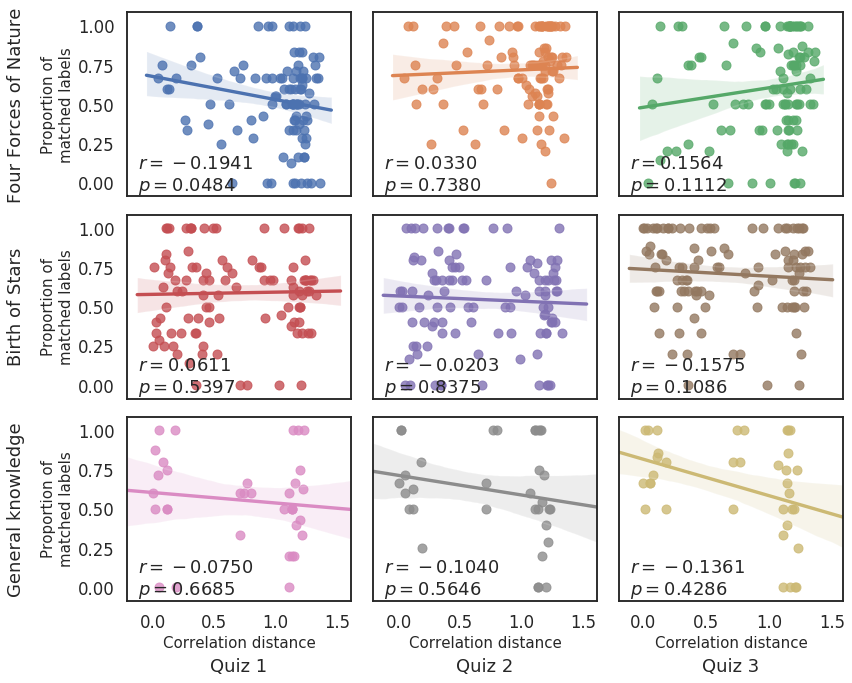

In [336]:
ALL_DATA = dict()
question_ix_ranges = {
    'forces': (0, 15),
    'bos': (15, 30),
    'general': (30, 39)
}

for lecture in ('forces', 'bos', 'general'):
    ALL_DATA[lecture] = dict()
    lec_questions = exp.get_question_vecs(lectures=lecture)
    corr_dists = pdist(lec_questions, 'correlation')
    
    for qset in range(3):
        ALL_DATA[lecture][qset] = dict()
        prop_labels_same = []
        
        for q1 in range(*question_ix_ranges[lecture]):
            for q2 in range(q1 + 1, question_ix_ranges[lecture][1]):
                labels_same = []
                
                for p in exp.participants:
                    p_data = p.get_data(lecture=lecture, qset=qset)
                    q_pair_rows = p_data['qID'].isin((q1 + 1, q2 + 1))
                    
                    # only include participants who were shown both questions
                    if q_pair_rows.sum() == 2:
                        labels_match = p_data.loc[q_pair_rows, 'accuracy'].nunique() == 1
                        labels_same.append(int(labels_match))

                if len(labels_same) > 0:
                    prop_labels_same.append(sum(labels_same) / len(labels_same))
                else:
                    prop_labels_same.append(np.nan)
                    
        # drop question pairs no participants viewed together
        seen_pairs = np.argwhere(~np.isnan(prop_labels_same)).ravel()
        ALL_DATA[lecture][qset]['corr_dists'] = corr_dists[seen_pairs]
        ALL_DATA[lecture][qset]['prop_labels_same'] = np.array(prop_labels_same)[seen_pairs]
        
lec_titles = {
    'forces': 'Four Forces of Nature',
    'bos': 'Birth of Stars',
    'general': 'General knowledge'
}

fig, axarr = plt.subplots(3, 3, sharex='col', sharey='row', figsize=(12, 10))
axarr = axarr.ravel()
axis_ix = 0

for lecture in ALL_DATA.keys():
    for qset in range(3):
        ax = axarr[axis_ix]
        corr_dists = ALL_DATA[lecture][qset]['corr_dists']
        prop_labels_same = ALL_DATA[lecture][qset]['prop_labels_same']
        sns.regplot(corr_dists, prop_labels_same, ax=ax)
        
        r, p = pearsonr(1 - r2z(1 - corr_dists), prop_labels_same)
        r = f"r = {r:.4f}"
        p = f"p = {p:.4f}"
        ax.text(.05, 0, f"${r}$\n${p}$", 
                horizontalalignment='left', 
                verticalalignment='bottom', 
                transform=ax.transAxes,
                fontdict={'fontsize': 'medium'})
        
        if axis_ix > 5:
            ax.set_xlabel('Correlation distance', 
                          fontdict={'fontsize': 'small'})
            ax.annotate(f'Quiz {qset + 1}', 
                        xy=(.5, -.5), 
                        xycoords=ax.xaxis.label, 
                        size='medium', 
                        ha='center', 
                        va='top')
            
        if not axis_ix % 3:
            ax.set_ylabel('Proportion of\nmatched labels', 
                          fontdict={'fontsize': 'small'})
            ax.annotate(lec_titles[lecture],
                        xy=(-.5, .5), 
                        xycoords=ax.yaxis.label, 
                        size='medium', 
                        rotation=90,
                        ha='right', 
                        va='center')
        
        axis_ix += 1

plt.tight_layout()
plt.subplots_adjust(hspace=.1, wspace=.1)
# plt.savefig('question-acc-by-pdist.pdf', bbox_inches='tight')
plt.show()

In [388]:
from sklearn.manifold import MDS, Isomap
import matplotlib as mpl

In [345]:
mds_params = {
    'n_components': 2,
    'metric': True,
    'n_init': 4,
    'verbose': 1,
    'random_state': 0,
    'dissimilarity': 'precomputed'
}
mds_reducer = MDS(**mds_params)

In [346]:
embedding = mds_reducer.fit_transform(1 - np.corrcoef(exp.question_vectors[:15]))

breaking at iteration 43 with stress 6.87179565801448
breaking at iteration 57 with stress 7.163681848107567
breaking at iteration 83 with stress 7.223175906911524
breaking at iteration 67 with stress 6.716132058987204


In [360]:
colors = mpl.cm.rainbow(np.linspace(0, 1, 15))

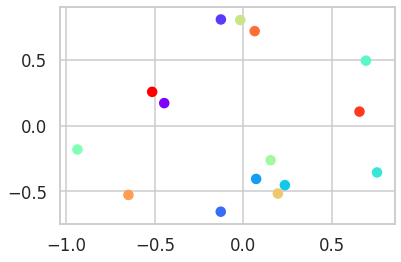

In [361]:
plt.scatter(embedding[:, 0], embedding[:, 1], c=colors)

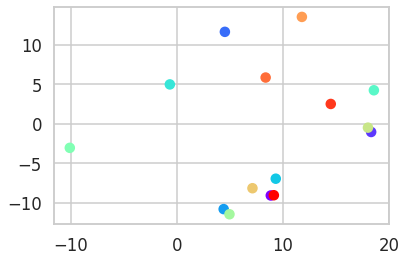

In [380]:
plt.scatter(exp.question_embeddings[:15, 0], exp.question_embeddings[:15, 1], c=colors)

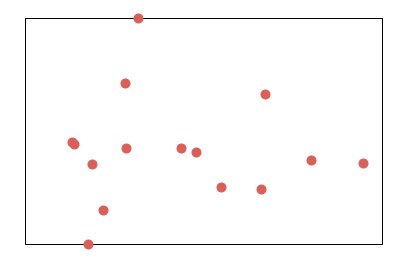

In [387]:
hyp.plot(exp.question_vectors[:15], ndims=2, fmt='o', colors=colors)

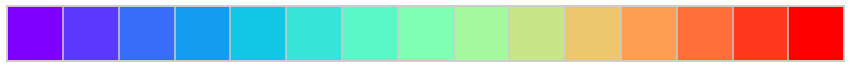

In [373]:
sns.palplot(colors)

In [386]:
pearsonr([.2, .6, .2], [0.1, 0.8, 0.1])

(1.0, 0.0)

## By-lecture versions
includes questions seen after viewing corresponding lecture

### Predict _Four Forces_ questions based on _Four Forces_ questions

In [6]:
question_corrs = np.corrcoef(exp.question_vectors)

In [13]:
# ORIGINAL VERSION
question_corrs = np.corrcoef(exp.question_vectors)
# set negative corrs to 0
question_corrs[question_corrs < 0] = 0
# rescale range (-1, 1) to (0, 1)
# question_corrs = (question_corrs + 1) / 2

t_scores = []
for p in tqdm(exp.participants, leave=False):
    correct_props = []
    incorrect_props = []
    p_data = p.get_data(lecture='forces', qset=(1, 2))
    # exclude participant with fewer than 2 correct & incorrect questions
    if p_data['accuracy'].sum() < 2 or p_data['accuracy'].sum() > 9:
        continue
        
    for ix, row in p_data.iterrows():
        # hold out one question at a time
        withheld_qid = row['qID']
        other_qdata = p_data.drop(ix)
        other_qids = other_qdata['qID']
        corrs = question_corrs[withheld_qid - 1, other_qids - 1]
        if (corrs == 0).all():
            continue
            
            
        weighted_prop = (corrs * other_qdata['accuracy']).sum() / corrs.sum()
        if row['accuracy']:
            correct_props.append(weighted_prop)
        else:
            incorrect_props.append(weighted_prop)
            
    if len(correct_props) == 1:
        t = -ttest_1samp(incorrect_props, correct_props[0]).statistic
    elif len(incorrect_props) == 1:
        t = ttest_1samp(correct_props, incorrect_props[0]).statistic
    else:
        t = ttest_ind(correct_props, incorrect_props).statistic
        
    t_scores.append(t)
    
ttest_1samp(t_scores, 0)

Ttest_1sampResult(statistic=-5.081891653504748, pvalue=8.615110940147054e-06)

In [287]:
# PERMUTATION CORRECTION VERSION
question_corrs = np.corrcoef(exp.question_vectors)
# set negative corrs to 0
# question_corrs[question_corrs < 0] = 0
# rescale range (-1, 1) to (0, 1)
question_corrs = (question_corrs + 1) / 2

t_scores = []
for p in tqdm(exp.participants, leave=False):
    correct_props = []
    incorrect_props = []
    p_data = p.get_data(lecture='forces', qset=(1, 2))
    # exclude participant with fewer than 2 correct & incorrect questions
    if p_data['accuracy'].sum() < 2 or p_data['accuracy'].sum() > 8:
        continue
        
    for ix, row in p_data.iterrows():
        # hold out one question at a time
        withheld_qid = row['qID']
        other_qdata = p_data.drop(ix)
        other_qids = other_qdata['qID']
        corrs = question_corrs[withheld_qid - 1, other_qids - 1]
        weighted_prop = permute_prop_correct(corrs, 
                                             other_qdata['accuracy'].values, 
                                             random_seed=0)
        if row['accuracy']:
            correct_props.append(weighted_prop)
        else:
            incorrect_props.append(weighted_prop)
            
    if len(correct_props) == 1:
        t = -ttest_1samp(incorrect_props, correct_props[0]).statistic
    elif len(incorrect_props) == 1:
        t = ttest_1samp(correct_props, incorrect_props[0]).statistic
    else:
        t = ttest_ind(correct_props, incorrect_props).statistic
        
    t_scores.append(t)
    
ttest_1samp(t_scores, 0)

Ttest_1sampResult(statistic=-0.25142288696178344, pvalue=0.8032602938171355)

In [350]:
# CORRELATION TIME SERIES INV DIFF VERSION
lec_q_corrs = 1 - cdist(exp.question_vectors[:15], exp.forces_traj, 'correlation')
corr_diffs = np.zeros((15, 15), dtype=np.float64)
for q1 in range(15):
    q1_corr_ts = lec_q_corrs[q1]
    for q2 in range(q1 + 1, 15):
        q2_corr_ts = lec_q_corrs[q2]
        diff = np.mean(np.abs(r2z(q1_corr_ts) - r2z(q2_corr_ts)))
        corr_diffs[q1, q2] = diff
        corr_diffs[q2, q1] = diff
        
# invert (difference -> similarity)
corr_weights = 1 - corr_diffs

t_scores = []
for p in exp.participants:
    correct_props = []
    incorrect_props = []
    p_data = p.get_data(lecture='forces', qset=(1, 2))
    # exclude participant with fewer than 2 correct & incorrect questions
    if p_data['accuracy'].sum() < 2 or p_data['accuracy'].sum() > 8:
        continue
        
    for ix, row in p_data.iterrows():
        # hold out one question at a time
        withheld_qid = row['qID']
        other_qdata = p_data.drop(ix)
        other_qids = other_qdata['qID']
        weights = corr_weights[withheld_qid - 1, other_qids - 1]
        weighted_prop = (weights * other_qdata['accuracy']).sum() / weights.sum()
        
        if row['accuracy']:
            correct_props.append(weighted_prop)
        else:
            incorrect_props.append(weighted_prop)
            
    if len(correct_props) == 1:
        t = -ttest_1samp(incorrect_props, correct_props[0]).statistic
    elif len(incorrect_props) == 1:
        t = ttest_1samp(correct_props, incorrect_props[0]).statistic
    else:
        t = ttest_ind(correct_props, incorrect_props).statistic
        
    t_scores.append(t)
    
ttest_1samp(t_scores, 0)

Ttest_1sampResult(statistic=-2.7821245790487126, pvalue=0.009396936672123898)

In [356]:
# CORRELATION TIME SERIES CORRELATION VERSION
lec_q_corrs = 1 - cdist(exp.question_vectors[:15], exp.forces_traj, 'correlation')
corr_corrs = np.ones((15, 15), dtype=np.float64)
for q1 in range(15):
    q1_corr_ts = lec_q_corrs[q1]
    for q2 in range(q1 + 1, 15):
        q2_corr_ts = lec_q_corrs[q2]
        c = pearsonr(r2z(q1_corr_ts), r2z(q2_corr_ts))[0]
        corr_corrs[q1, q2] = c
        corr_corrs[q2, q1] = c
                
# # rescale range (-1, 1) to (0, 1)
cc_weights = (corr_corrs + 1) / 2

t_scores = []
for p in exp.participants:
    correct_props = []
    incorrect_props = []
    p_data = p.get_data(lecture='forces', qset=(1, 2))
    # exclude participant with fewer than 2 correct & incorrect questions
    if p_data['accuracy'].sum() < 2 or p_data['accuracy'].sum() > 8:
        continue
        
    for ix, row in p_data.iterrows():
        # hold out one question at a time
        withheld_qid = row['qID']
        other_qdata = p_data.drop(ix)
        other_qids = other_qdata['qID']
        weights = cc_weights[withheld_qid - 1, other_qids - 1]
        weighted_prop = (weights * other_qdata['accuracy']).sum() / weights.sum()
        
        if row['accuracy']:
            correct_props.append(weighted_prop)
        else:
            incorrect_props.append(weighted_prop)
            
    if len(correct_props) == 1:
        t = -ttest_1samp(incorrect_props, correct_props[0]).statistic
    elif len(incorrect_props) == 1:
        t = ttest_1samp(correct_props, incorrect_props[0]).statistic
    else:
        t = ttest_ind(correct_props, incorrect_props).statistic
        
    t_scores.append(t)
    
ttest_1samp(t_scores, 0)

Ttest_1sampResult(statistic=-9.304414372170486, pvalue=3.300318301083592e-10)

In [133]:
lec_q_corrs = 1 - cdist(exp.question_vectors[:15], exp.forces_traj, 'correlation')

for corrs_ts in lec_q_corrs:
    # calling .item() serves as assertion that only 1 timepoint has max value
    max_tpt = np.argwhere(corrs_ts == corrs_ts.max()).item()
    

In [356]:
# HELD-IN QS' CORRELATIONS AT HELD-OUT Q'S TOP TIMEPOINT(S)
lec_q_corrs = 1 - cdist(exp.question_vectors[:15], exp.forces_traj, 'correlation')

t_scores = []
for p in exp.participants:
    correct_props = []
    incorrect_props = []
    p_data = p.get_data(lecture='forces', qset=(1, 2))
    # exclude participant with fewer than 2 correct & incorrect questions
    if p_data['accuracy'].sum() < 2 or p_data['accuracy'].sum() > 8:
        continue
        
    for ix, row in p_data.iterrows():
        # hold out one question at a time
        withheld_qid = row['qID']
        other_qdata = p_data.drop(ix)
        other_qids = other_qdata['qID']
        weights = cc_weights[withheld_qid - 1, other_qids - 1]
        weighted_prop = (weights * other_qdata['accuracy']).sum() / weights.sum()
        
        if row['accuracy']:
            correct_props.append(weighted_prop)
        else:
            incorrect_props.append(weighted_prop)
            
    if len(correct_props) == 1:
        t = -ttest_1samp(incorrect_props, correct_props[0]).statistic
    elif len(incorrect_props) == 1:
        t = ttest_1samp(correct_props, incorrect_props[0]).statistic
    else:
        t = ttest_ind(correct_props, incorrect_props).statistic
        
    t_scores.append(t)
    
ttest_1samp(t_scores, 0)

Ttest_1sampResult(statistic=-9.304414372170486, pvalue=3.300318301083592e-10)

In [288]:
# DYNAMIC TIME WARPING VERSION
lec_q_corrs = 1 - cdist(exp.question_vectors[:15], exp.forces_traj, 'correlation')
dtw_dists = np.zeros((15, 15), dtype=np.float64)
for q1 in range(15):
    q1_corr_ts = lec_q_corrs[q1]
    for q2 in range(q1 + 1, 15):
        q2_corr_ts = lec_q_corrs[q2]
        dist, _ = fastdtw(r2z(q1_corr_ts), r2z(q2_corr_ts), exp.forces_traj.shape[0])
        dtw_dists[q1, q2] = dist
        dtw_dists[q2, q1] = dist
        
# invert and rescale to (0, 1)
dtw_weights = 1 - (dtw_dists / dtw_dists.max())

t_scores = []
for p in exp.participants:
    correct_props = []
    incorrect_props = []
    p_data = p.get_data(lecture='forces', qset=(1, 2))
    # exclude participant with fewer than 2 correct & incorrect questions
    if p_data['accuracy'].sum() < 2 or p_data['accuracy'].sum() > 8:
        continue
        
    for ix, row in p_data.iterrows():
        # hold out one question at a time
        withheld_qid = row['qID']
        other_qdata = p_data.drop(ix)
        other_qids = other_qdata['qID']
        weights = dtw_weights[withheld_qid - 1, other_qids - 1]
        weighted_prop = (weights * other_qdata['accuracy']).sum() / weights.sum()
        
        if row['accuracy']:
            correct_props.append(weighted_prop)
        else:
            incorrect_props.append(weighted_prop)
            
    if len(correct_props) == 1:
        t = -ttest_1samp(incorrect_props, correct_props[0]).statistic
    elif len(incorrect_props) == 1:
        t = ttest_1samp(correct_props, incorrect_props[0]).statistic
    else:
        t = ttest_ind(correct_props, incorrect_props).statistic
        
    t_scores.append(t)
    
ttest_1samp(t_scores, 0)

Ttest_1sampResult(statistic=-4.836591596387348, pvalue=3.994516123355765e-05)

In [412]:
# Z-SCORED CORRELATIONS VERSION
question_corrs = np.corrcoef(exp.question_vectors)
# set negative corrs to 0
# question_corrs[question_corrs < 0] = 0
# rescale range (-1, 1) to (0, 1)
# question_corrs = (question_corrs + 1) / 2
forces_corrs = question_corrs[:15, :15]
forces_corrs_triu = forces_corrs[np.triu_indices_from(forces_corrs, k=1)]
forces_zcorrs = zmap(forces_corrs.flatten(), forces_corrs_triu).reshape(forces_corrs.shape)
zcorr_weights = (forces_zcorrs - forces_zcorrs.min()) / (forces_zcorrs.max() - forces_zcorrs.min())


t_scores = []
for p in tqdm(exp.participants, leave=False):
    correct_props = []
    incorrect_props = []
    p_data = p.get_data(lecture='forces', qset=(1, 2))
    # exclude participant with fewer than 2 correct & incorrect questions
    if p_data['accuracy'].sum() < 2 or p_data['accuracy'].sum() > 8:
        continue
        
    for ix, row in p_data.iterrows():
        # hold out one question at a time
        withheld_qid = row['qID']
        other_qdata = p_data.drop(ix)
        other_qids = other_qdata['qID']
        zcorrs = zcorr_weights[withheld_qid - 1, other_qids - 1]
        if (zcorrs == 0).all():
            # all correlations were 0
            continue
            
        weighted_prop = (zcorrs * other_qdata['accuracy']).sum() / zcorrs.sum()
        if np.isnan(weighted_prop):
            asdf
        if row['accuracy']:
            correct_props.append(weighted_prop)
        else:
            incorrect_props.append(weighted_prop)
            
    if len(correct_props) == 1:
        t = -ttest_1samp(incorrect_props, correct_props[0]).statistic
    elif len(incorrect_props) == 1:
        t = ttest_1samp(correct_props, incorrect_props[0]).statistic
    else:
        t = ttest_ind(correct_props, incorrect_props).statistic
        
    if np.isnan(t):
        asdjfkl
    t_scores.append(t)
    
ttest_1samp(t_scores, 0)

Ttest_1sampResult(statistic=-8.208286936915572, pvalue=4.7435855401712915e-09)

In [417]:
abs(15 - -4)

19

In [ ]:
15

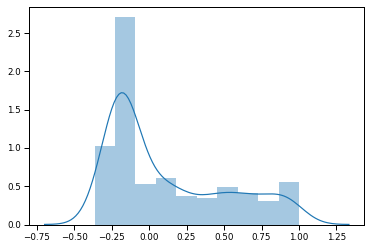

In [385]:
corrs_tu = question_corrs[np.triu_indices_from(question_corrs, k=1)]
sns.distplot(corrs_tu)

## Distplots

t = -3.2584
p = 0.0011


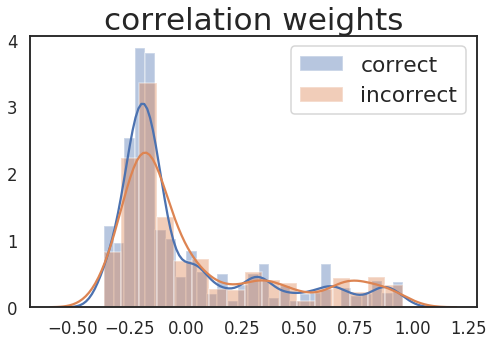

In [251]:
question_corrs = np.corrcoef(exp.question_vectors)
# set negative corrs to 0
# question_corrs[question_corrs < 0] = 0
# rescale range (-1, 1) to (0, 1)
# question_corrs = (question_corrs + 1) / 2

correct_corrs = []
incorrect_corrs = []
for p in exp.participants:
    p_data = p.get_data(lecture='forces', qset=(1, 2))
    if p_data['accuracy'].sum() < 1 or p_data['accuracy'].sum() > 9:
        continue
        
    for ix, row in p_data.iterrows():
        withheld_qid = row['qID']
        other_qdata = p_data.drop(ix)
        other_qids = other_qdata['qID']
        corrs = question_corrs[withheld_qid - 1, other_qids - 1]
        if (corrs == 0).all():
            continue
            
        if row['accuracy'] == 1:
            correct_corrs.extend(list(corrs))
        else:
            incorrect_corrs.extend(list(corrs))
            
fig, ax = plt.subplots(1)
fig.set_size_inches(8, 5)
sns.distplot(correct_corrs, label='correct', ax=ax)
sns.distplot(incorrect_corrs, label='incorrect', ax=ax)
t, p = ttest_ind(correct_corrs, incorrect_corrs)
t = f"t = {t:.4f}"
p = f"p = {p:.4f}"
print(f"{t}\n{p}")
# ax.text(.2, 15, f"{t}\n{p}", fontdict={'fontsize': 'xx-large'})
plt.legend(fontsize='large')
ax.set_title("correlation weights", fontdict={'fontsize': 'xx-large'})
plt.show()

t = -5.6868
p = 0.0000


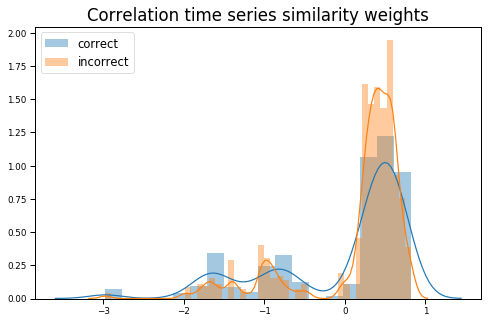

In [341]:
lec_q_corrs = 1 - cdist(exp.question_vectors[:15], exp.forces_traj, 'correlation')
corr_diffs = np.zeros((15, 15), dtype=np.float64)
for q1 in range(15):
    q1_corr_ts = lec_q_corrs[q1]
    for q2 in range(q1 + 1, 15):
        q2_corr_ts = lec_q_corrs[q2]
        diff = np.mean(np.abs(r2z(q1_corr_ts) - r2z(q2_corr_ts)))
        corr_diffs[q1, q2] = diff
        corr_diffs[q2, q1] = diff
        
# invert (difference -> similarity)
corr_weights = 1 - corr_diffs

correct_weights = []
incorrect_weights = []
for p in exp.participants:
    p_data = p.get_data(lecture='forces', qset=(1, 2))
    if p_data['accuracy'].sum() < 2 or p_data['accuracy'].sum() > 8:
        continue
        
    for ix, row in p_data.iterrows():
        # hold out one question at a time
        withheld_qid = row['qID']
        other_qdata = p_data.drop(ix)
        other_qids = other_qdata['qID']
        weights = corr_weights[withheld_qid - 1, other_qids - 1]
        if row['accuracy'] == 1:
            correct_weights.extend(list(weights))
        else:
            assert row['accuracy'] == 0
            incorrect_weights.extend(list(weights))
            
fig, ax = plt.subplots(1)
fig.set_size_inches(8, 5)
sns.distplot(correct_weights, label='correct', ax=ax)
sns.distplot(incorrect_weights, label='incorrect', ax=ax)
t, p = ttest_ind(correct_weights, incorrect_weights)
t = f"t = {t:.4f}"
p = f"p = {p:.4f}"
print(f"{t}\n{p}")
# ax.text(.2, 15, f"{t}\n{p}", fontdict={'fontsize': 'xx-large'})
plt.legend(fontsize='large')
ax.set_title("Correlation time series similarity weights", fontdict={'fontsize': 'xx-large'})
plt.show()

t = -6.5705
p = 0.0000


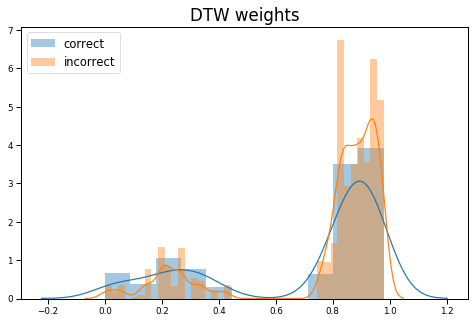

In [289]:
correct_weights = []
incorrect_weights = []
for p in exp.participants:
    p_data = p.get_data(lecture='forces', qset=(1, 2))
    if p_data['accuracy'].sum() < 2 or p_data['accuracy'].sum() > 8:
        continue
        
    for ix, row in p_data.iterrows():
        # hold out one question at a time
        withheld_qid = row['qID']
        other_qdata = p_data.drop(ix)
        other_qids = other_qdata['qID']
        weights = dtw_weights[withheld_qid - 1, other_qids - 1]
#         weights = 1 / dtw_dists[withheld_qid - 1, other_qids - 1]
        if row['accuracy'] == 1:
            correct_weights.extend(list(weights))
        else:
            assert row['accuracy'] == 0
            incorrect_weights.extend(list(weights))
            
fig, ax = plt.subplots(1)
fig.set_size_inches(8, 5)
sns.distplot(correct_weights, label='correct', ax=ax)
sns.distplot(incorrect_weights, label='incorrect', ax=ax)
t, p = ttest_ind(correct_weights, incorrect_weights)
t = f"t = {t:.4f}"
p = f"p = {p:.4f}"
print(f"{t}\n{p}")
# ax.text(.2, 15, f"{t}\n{p}", fontdict={'fontsize': 'xx-large'})
plt.legend(fontsize='large')
ax.set_title("DTW weights", fontdict={'fontsize': 'xx-large'})
plt.show()

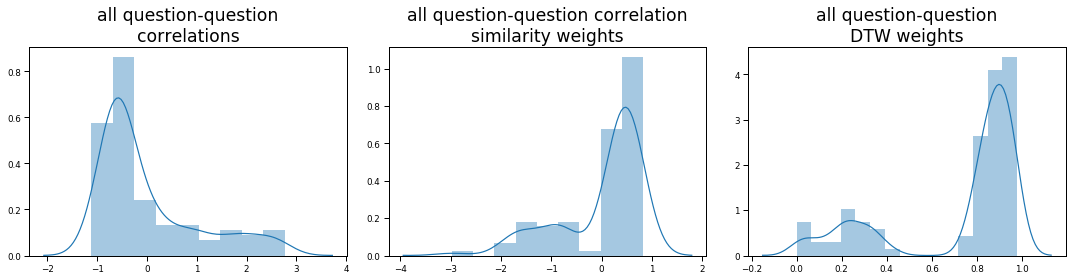

In [362]:
question_corrs = np.corrcoef(exp.question_vectors)
forces_corrs = question_corrs[:15, :15]
corrs_tu = forces_corrs[np.triu_indices_from(forces_corrs, k=1)]
corr_weights_tu = corr_weights[np.triu_indices_from(corr_weights, k=1)]
dtw_weights_tu = dtw_weights[np.triu_indices_from(dtw_weights, k=1)]

fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15, 4))
sns.distplot(corrs_tu, ax=ax1)
ax1.set_title('all question-question\ncorrelations', fontdict={'fontsize': 'xx-large'})

sns.distplot(corr_weights_tu, ax=ax2)
ax2.set_title('all question-question correlation\nsimilarity weights', fontdict={'fontsize': 'xx-large'})


sns.distplot(dtw_weights_tu, ax=ax3)
ax3.set_title('all question-question\nDTW weights', fontdict={'fontsize': 'xx-large'})

plt.subplots_adjust()
plt.tight_layout()
plt.show()

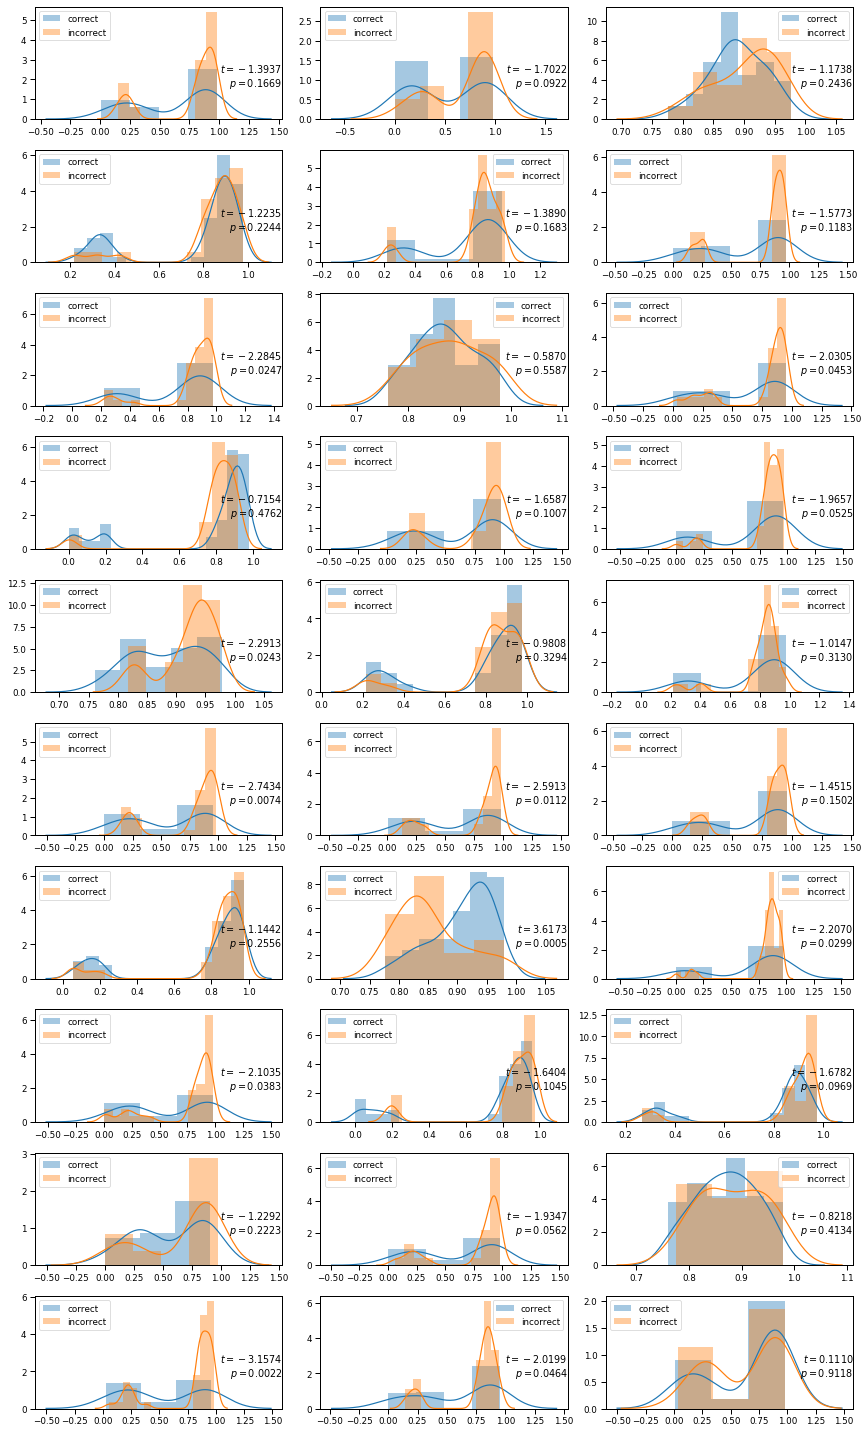

In [292]:
correct_weights = []
incorrect_weights = []
for p in exp.participants:
    cp_weights = []
    icp_weights = []
    p_data = p.get_data(lecture='forces', qset=(1, 2))
    if p_data['accuracy'].sum() < 2 or p_data['accuracy'].sum() > 8:
        continue
        
    for ix, row in p_data.iterrows():
        # hold out one question at a time
        withheld_qid = row['qID']
        other_qdata = p_data.drop(ix)
        other_qids = other_qdata['qID']
        weights = dtw_weights[withheld_qid - 1, other_qids - 1]
        if row['accuracy'] == 1:
            cp_weights.extend(list(weights))
        else:
            assert row['accuracy'] == 0
            icp_weights.extend(list(weights))
            
    correct_weights.append(cp_weights)
    incorrect_weights.append(icp_weights)
    
fig, axarr = plt.subplots(10, 3, figsize=(12, 20))
axarr = axarr.flatten()

for i, ax in enumerate(axarr):
    sns.distplot(correct_weights[i], label='correct', ax=ax)
    sns.distplot(incorrect_weights[i], label='incorrect', ax=ax)
    t, p = ttest_ind(correct_weights[i], incorrect_weights[i])
    t = f"t = {t:.4f}"
    p = f"p = {p:.4f}"
    ax.text(1, .5, f"${t}$\n${p}$", horizontalalignment='right', verticalalignment='top', transform=ax.transAxes)
    ax.legend()
    
plt.subplots_adjust()
plt.tight_layout()
plt.show()

In [221]:
other_qdata

,qID,accuracy,response,qset,lecture
15,6,1,A,1,1
18,7,0,D,1,1
20,2,1,A,1,1
22,8,1,A,1,1
23,9,0,D,1,1
26,11,1,A,2,1
31,12,0,B,2,1
32,3,1,A,2,1
33,5,0,C,2,1


In [45]:
row.to_frame().T

,qID,accuracy,response,qset,lecture
38,5,1,A,2,1


In [40]:
question_corrs[withheld_qid - 1, other_qids - 1]

array([ 0.63948613, -0.19010996,  0.96012219,  0.72449153, -0.14140369,
       -0.08210206,  0.80770787, -0.09486607, -0.00261954])

In [62]:
question_corrs = np.corrcoef(exp.question_vectors)
correct_weights = []
incorrect_weights = []
for p in exp.participants:
    p_data = p.get_data(lecture='forces', qset=(1, 2))
    if p_data['accuracy'].sum() < 2 or p_data['accuracy'].sum() > 8:
        continue
        
    for ix, row in p_data.iterrows():
        # hold out one question at a time
        withheld_qid = row['qID']
        other_qdata = p_data.drop(ix)
        other_qids = other_qdata['qID']
        weights = question_corrs[withheld_qid - 1, other_qids - 1]
        if row['accuracy'] == 1:
            correct_weights.extend(list(weights))
        else:
            assert row['accuracy'] == 0
            incorrect_weights.extend(list(weights))
            
correct_weights = np.array(correct_weights)
incorrect_weights = np.array(incorrect_weights)

print('all % negative:')
print((question_corrs[:15, :15].ravel() < 0).sum() / question_corrs[:15, :15].ravel().shape[0])
print('correct % negative:')
print((correct_weights < 0).sum() / correct_weights.shape[0])
print('incorrect % negative:')
print((incorrect_weights < 0).sum() / incorrect_weights.shape[0])

all % negative:
0.6133333333333333
correct % negative:
0.6781214203894617
incorrect % negative:
0.6477987421383647


In [181]:
import hypertools as hyp

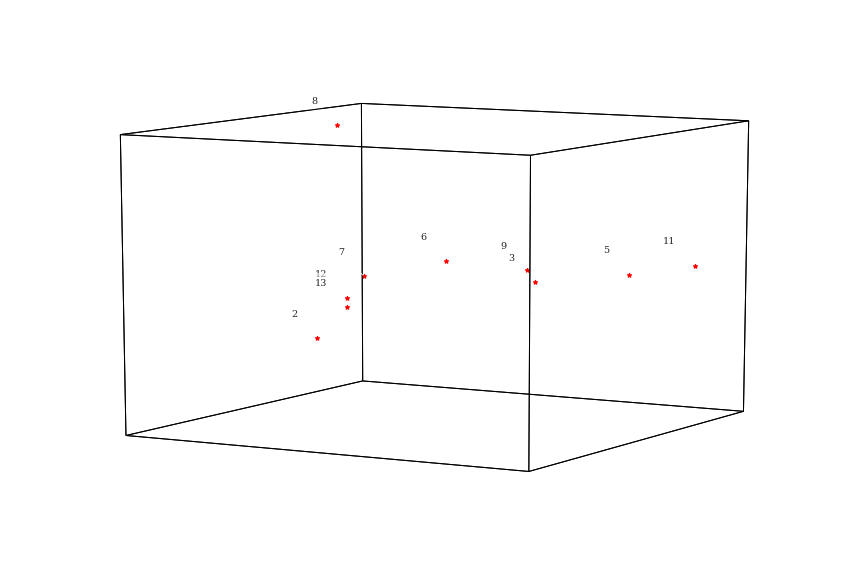

In [196]:
hyp.plot(exp.question_vectors[p_data['qID'] - 1], fmt='r*', size=(12, 8), labels=list(p_data['qID']))

In [193]:
p_data

,qID,accuracy,response,qset,lecture
15,6,1,A,1,1
18,7,0,D,1,1
20,2,1,A,1,1
22,8,1,A,1,1
23,9,0,D,1,1
26,11,1,A,2,1
31,12,0,B,2,1
32,3,1,A,2,1
33,5,0,C,2,1
35,13,1,A,2,1


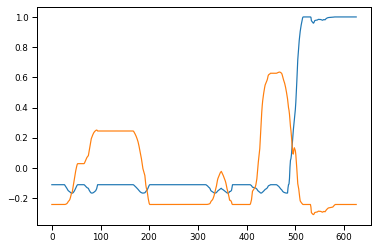

In [92]:
plt.plot(lec_q_corrs[11])
plt.plot(lec_q_corrs[12])
# plt.plot(lec_q_corrs[13])

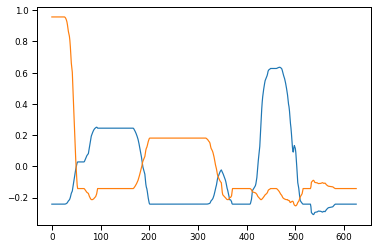

In [93]:
plt.plot(lec_q_corrs[12])
plt.plot(lec_q_corrs[13])

In [496]:
t_scores = []
for p in exp.participants:
    weighted_advantage = []
    p_data = p.get_data(lecture='forces', qset=(1, 2))
    # exclude participant who got all (or no) Four Forces-related 
    # questions correct after viewing lecture
    # (all correct: P1, P11, P17, P19, P26, P40, P41, P43)
    # (none correct: no participants)
    if p_data['accuracy'].all() or not p_data['accuracy'].any():
        continue
        
    for ix, row in p_data.iterrows():
        # hold out one question at a time
        withheld_qid = row['qID']
        other_qdata = p_data.drop(ix)
        other_qids = other_qdata['qID']
        corrs = question_corrs[withheld_qid - 1, other_qids - 1]
        ####
#         weights = np.empty_like(corrs, dtype=int)
#         weights[corrs.argsort()] = np.arange(corrs.shape[0])
#         weighted_prop = ((weights * other_qdata['accuracy']).sum()) / (weights.sum())
        ####
        weighted_prop = ((corrs * other_qdata['accuracy']).sum()) / (corrs.sum())
        simple_prop = other_qdata['accuracy'].sum() / other_qdata.shape[0]
        weighted_simple_diff = weighted_prop - simple_prop
        if row['accuracy'] == 0:
            weighted_simple_diff *= -1
        
        weighted_advantage.append(weighted_simple_diff)
        
    t = ttest_1samp(weighted_advantage, 0).statistic
    t_scores.append(t)
    
ttest_1samp(t_scores, 0)

Ttest_1sampResult(statistic=-2.313951335628406, pvalue=0.02575907573301038)

In [185]:
t_scores = []
for p in exp.participants:
    correct_props = []
    incorrect_props = []
    p_data = p.get_data(lecture='forces', qset=(1, 2))
    # exclude participant who got all (or no) Four Forces-related 
    # questions correct after viewing lecture
    # (all correct: P1, P11, P17, P19, P26, P40, P41, P43)
    # (none correct: no participants)
    if p_data['accuracy'].all() or not p_data['accuracy'].any():
        continue
        
    for ix, row in p_data.iterrows():
        # hold out one question at a time
        withheld_qid = row['qID']
        other_qdata = p_data.drop(ix)
        other_qids = other_qdata['qID']
        corrs = question_corrs[withheld_qid - 1, other_qids - 1]
        weights = np.empty_like(corrs, dtype=int)
        weights[corrs.argsort()] = np.arange(corrs.shape[0])
        
        
        weighted_prop = (weights * other_qdata['accuracy']).sum() / weights.sum()
#         print(weighted_prop)
        if row['accuracy']:
            correct_props.append(weighted_prop)
        else:
            incorrect_props.append(weighted_prop)
            
    if len(correct_props) == 1:
        t = -ttest_1samp(incorrect_props, correct_props[0]).statistic
    elif len(incorrect_props) == 1:
        t = ttest_1samp(correct_props, incorrect_props[0]).statistic
    else:
        t = ttest_ind(correct_props, incorrect_props).statistic
        
    t_scores.append(t)
    
ttest_1samp(t_scores, 0)

Ttest_1sampResult(statistic=-7.60230228974491, pvalue=2.357333246141344e-09)

### Predict _Birth of Stars_ questions based on _Birth of Stars_ questions

In [252]:
t_scores = []
for p in exp.participants:
    correct_props = []
    incorrect_props = []
    p_data = p.get_data(lecture='bos', qset=2)
    if p_data['accuracy'].all() or not p_data['accuracy'].any():
        continue
        
    for ix, row in p_data.iterrows():
        # hold out one question at a time
        withheld_qid = row['qID']
        other_qdata = p_data.drop(ix)
        other_qids = other_qdata['qID']
        corrs = question_corrs[withheld_qid - 1, other_qids - 1]
        weighted_prop = (corrs * other_qdata['accuracy']).sum() / corrs.sum()
        if row['accuracy']:
            correct_props.append(weighted_prop)
        else:
            incorrect_props.append(weighted_prop)
            
    if len(correct_props) == 1:
        t = -ttest_1samp(incorrect_props, correct_props[0]).statistic
    elif len(incorrect_props) == 1:
        t = ttest_1samp(correct_props, incorrect_props[0]).statistic
    else:
        t = ttest_ind(correct_props, incorrect_props).statistic
        
    t_scores.append(t)

ttest_1samp(t_scores, 0)

a
a
a
a
a
a
a
a
a
a
a
a
a
a
a
a


Ttest_1sampResult(statistic=-2.5931874649666584, pvalue=0.014748745207746307)

In [241]:
for p in exp.participants:
    correct_props = []
    incorrect_props = []
    p_data = p.get_data(lecture='bos', qset=2)
    # exclude participant who got all (or no) Birth of Stars-related 
    # questions correct after viewing lecture
    # (all correct: P1, P11, P17, P19, P26, P40, P41, P43)
    if p_data['accuracy'].all():
        print(p.subID)
    elif not p_data['accuracy'].any():
        print('a', p.subID)

P1
P2
P8
P9
P10
P11
P12
P15
P18
P19
P20
P21
P22
P24
P35
P40
P41
P44
P45
P46


## Simplest version: within participant, within question set

In [140]:
# t_scores = []
# for p in exp.participants:
#     correct_avgs = []
#     incorrect_avgs = []
#     for qset in range(3):
#         qset_data = p.get_data(qset=qset)
#         # exclude quizzes where participant got all or no questions correct
#         # (all correct: P1, qset 3; P8, qset 3; P19, qsets 2 & 3; P41, qset 3)
#         if qset_data['accuracy'].all() or not qset_data['accuracy'].any():
#             continue
        
#         for ix, row in qset_data.iterrows():
#             # hold out one question at a time
#             other_qdata = qset_data.drop(ix)
#             withheld_qid = row['qID']
#             other_qids = other_qdata['qID']
#             corrs = question_corrs[withheld_qid - 1, other_qids - 1]
#             weighted_avg = (corrs * other_qdata['accuracy']).sum() / corrs.sum()
#             if row['accuracy']:
#                 correct_avgs.append(weighted_avg)
#             else:
#                 incorrect_avgs.append(weighted_avg)
                
    

In [119]:
from scipy.stats import ttest_rel
ff_props = []
bos_props = []
gen_props = []
for qset in range(3):
    ff_qset_props = []
    bos_qset_props = []
    gen_qset_props = []
    for p in exp.participants:
        data = p.get_data(qset=qset)
        ff_qset_props.append((data[data['lecture'] == 1]['accuracy'] == 1).sum() / 5)
        bos_qset_props.append((data[data['lecture'] == 2]['accuracy'] == 1).sum() / 5)
        gen_qset_props.append((data[data['lecture'] == 0]['accuracy'] == 1).sum() / 3)
        
    ff_props.append(ff_qset_props)
    bos_props.append(bos_qset_props)
    gen_props.append(gen_qset_props)
    
print(ttest_rel(ff_props[0], ff_props[1]))
print(ttest_rel(ff_props[1], ff_props[2]))
print(ttest_rel(bos_props[0], bos_props[1]))
print(ttest_rel(bos_props[1], bos_props[2]))
print(ttest_rel(gen_props[0], gen_props[1]))
print(ttest_rel(gen_props[1], gen_props[2]))

Ttest_relResult(statistic=-8.986143712193757, pvalue=6.182864070607308e-12)
Ttest_relResult(statistic=0.2696299255199708, pvalue=0.7885772334167714)
Ttest_relResult(statistic=0.6588285953950666, pvalue=0.5130900151074996)
Ttest_relResult(statistic=-10.934644061312044, pvalue=9.5431928023157e-15)
Ttest_relResult(statistic=-1.2004900959975615, pvalue=0.2357206807000065)
Ttest_relResult(statistic=-1.5623450931857945, pvalue=0.12464280772281883)


In [413]:
np.corrcoef(exp.forces_traj)[np.triu_indices_from(np.corrcoef(exp.forces_traj), k=1)].mean()

0.08938172962602556

In [414]:
forces_corrs_triu.mean()

0.01651153523125447

In [416]:
pearsonr([1, 1, 3, 1], [1, 3, 1, 1])

(-0.33333333333333337, 0.6666666666666666)

# OLD / SCRATCH

## Recreate 2D embedding space grid

In [60]:
# exp = Experiment()
# reducer = exp.fit_umap
# embeddings = reducer.embedding_

# resolution = 100
# x_min, y_min = embeddings.min(axis=0) // 1 - 3
# x_max, y_max = embeddings.max(axis=0) // 1 + 3
# x_step = (x_max - x_min) / resolution
# y_step = (y_max - y_min) / resolution
# xs = np.arange(x_min, x_max, x_step)
# ys = np.arange(y_min, y_max, y_step)

# X, Y = np.meshgrid(xs, ys)
# xy_grid = np.empty((resolution, resolution, 2), dtype=np.float64)
# for (x_ix, y_ix), X_val in np.ndenumerate(X):
#     xy_grid[x_ix, y_ix] = (X_val, Y[x_ix, y_ix])
    
# vertices = xy_grid.reshape(resolution**2, 2)

## Construct knowledge maps for _individual_ lectures

In [61]:
# pbar = tqdm(total=N_PARTICIPANTS*6, leave=False)
# for qset in range(3):
#     for lecture in ('forces', 'bos'):
#         store_key = f'{lecture}_qset{qset}'
#         # for computing across-participant avg knowledge maps
#         maps_arr = np.empty((N_PARTICIPANTS, resolution, resolution), dtype=np.float64)
#         for i, p in enumerate(exp.participants):
#             maps_arr[i] = p.construct_knowledge_map(exp, 
#                                                     lecture=lecture, 
#                                                     qset=qset, 
#                                                     map_grid=xy_grid, 
#                                                     rbf_width=50, 
#                                                     rbf_metric='euclidean', 
#                                                     store=store_key)
#             pbar.update()
            
#         exp.avg_participant.store_kmap(maps_arr.mean(axis=0), store_key)

In [62]:
# # save updated participant objects
# exp.save_participants(allow_overwrite=True)

## Does ability to learn lecture 1 content predict ability to learn lecture 2 content?

In [63]:
# lec1_learning = np.empty((participants.shape[0], resolution, resolution), dtype=np.float64)
# lec2_learning = np.empty((participants.shape[0], resolution, resolution), dtype=np.float64)

# for i, p in enumerate(participants):
#     lec1_before = p.get_kmap('forces_qset0')
#     lec1_after = p.get_kmap('forces_qset1')
#     lec1_learning[i] = lec1_after - lec1_before
    
#     lec2_before = p.get_kmap('bos_qset1')
#     lec2_after = p.get_kmap('bos_qset2')
#     lec2_learning[i] = lec2_after - lec2_before

In [64]:
# learning_rmap = np.empty_like(lec1_learning[0])
# learning_pmap = np.empty_like(learning_rmap)

# for row in range(100):
#     for col in range(100):
#         r, p = pearsonr(lec1_learning[:, row, col], lec2_learning[:, row, col])
#         learning_rmap[row, col] = r
#         learning_pmap[row, col] = p

In [65]:
# sns.heatmap(learning_rmap, vmin=-1, vmax=1)

In [66]:
# sns.heatmap(learning_pmap, vmin=0, vmax=1)